In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!python -m pip install tensorflow_text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 66.9 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd
import os

In [ ]:
df_train = pd.read_csv(r'/content/drive/MyDrive/NCKH_Trinh_Kien_Hoang/Dataset/KLTN/train.csv')
df_test = pd.read_csv(r'/content/drive/MyDrive/NCKH_Trinh_Kien_Hoang/Dataset/KLTN/test.csv')

In [ ]:
# Xáo trộn dữ liệu bằng phương thức sample
df_train = df_train.sample(frac=1).reset_index(drop=True)
# Xáo trộn dữ liệu bằng phương thức sample
df_test = df_test.sample(frac=1).reset_index(drop=True)

In [ ]:
df_train['source_code'] = df_train['source_code'].astype(str)
df_test['source_code'] = df_test['source_code'].astype(str)

In [ ]:
from keras.utils import to_categorical
y_train = df_train['label'].values
y_train = to_categorical(y_train)
y_test = df_test['label'].values
y_test = to_categorical(y_test)

In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.3, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(3, activation='softmax', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

optimizer = tf.keras.optimizers.Adam()

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=METRICS)

In [ ]:
model.fit(df_train['source_code'], y_train, epochs=10, batch_size=32)

Epoch 1/10
45/45 [==============================] - 22s 158ms/step - loss: 0.6416 - accuracy: 0.6509 - precision: 0.4537 - recall: 0.2318
Epoch 2/10
45/45 [==============================] - 7s 160ms/step - loss: 0.5937 - accuracy: 0.7034 - precision: 0.5846 - recall: 0.3809
Epoch 3/10
45/45 [==============================] - 7s 157ms/step - loss: 0.5692 - accuracy: 0.7277 - precision: 0.6249 - recall: 0.4580
Epoch 4/10
45/45 [==============================] - 7s 160ms/step - loss: 0.5654 - accuracy: 0.7293 - precision: 0.6205 - recall: 0.4841
Epoch 5/10
45/45 [==============================] - 7s 159ms/step - loss: 0.5518 - accuracy: 0.7282 - precision: 0.6148 - recall: 0.4940
Epoch 6/10
45/45 [==============================] - 8s 168ms/step - loss: 0.5433 - accuracy: 0.7442 - precision: 0.6444 - recall: 0.5187
Epoch 7/10
45/45 [==============================] - 7s 159ms/step - loss: 0.5440 - accuracy: 0.7392 - precision: 0.6305 - recall: 0.5258
Epoch 8/10
45/45 [======================

In [ ]:
model.evaluate(df_test['source_code'], y_test)

12/12 [==============================] - 3s 148ms/step - loss: 0.5510 - accuracy: 0.7156 - precision: 0.5922 - recall: 0.4718


[0.5509970188140869,
 0.7156308889389038,
 0.5921986103057861,
 0.4717514216899872]

In [ ]:
y_predicted = model.predict(df_test['source_code'])
# y_predicted = y_predicted.flatten()
# import numpy as np

# y_predicted = np.where(y_predicted > 0.5, 1, 0)
print(y_predicted)

12/12 [==============================] - 2s 144ms/step
[[0.09049973 0.22327055 0.6862297 ]
 [0.03068906 0.0494123  0.9198986 ]
 [0.15132847 0.4156926  0.43297893]
 ...
 [0.3588739  0.47678956 0.16433653]
 [0.46218407 0.4856059  0.05221001]
 [0.44338745 0.45309886 0.10351371]]


In [ ]:
import numpy as np
# Convert predictions to class labels
y_predicted_1 = np.argmax(y_predicted, axis=1)
y_test_1 = np.argmax(y_test, axis=1)

# Print classification report
from sklearn.metrics import classification_report
print(classification_report(y_test_1, y_predicted_1, digits=4))

              precision    recall  f1-score   support

           0     0.5926    0.4741    0.5267       135
           1     0.5349    0.4466    0.4868       103
           2     0.5750    0.7931    0.6667       116

    accuracy                         0.5706       354
   macro avg     0.5675    0.5713    0.5601       354
weighted avg     0.5700    0.5706    0.5610       354



In [ ]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test_1, y_predicted_1))

0.5706214689265536


In [ ]:
model.save('saved_model/bert_mutil_data')
acc = []
pre = []
rec = []
f1 = []
for i in range(11, 31):
  print(i)
  model = tf.keras.models.load_model('saved_model/bert_mutil_data')
  model.fit(df_train['source_code'], y_train, epochs=1, batch_size=32)
  y_predicted = model.predict(df_test['source_code'])
  y_predicted_1 = np.argmax(y_predicted, axis=1)
  y_test_1 = np.argmax(y_test, axis=1)
  metric = [i for i in classification_report(y_test_1, y_predicted_1, digits=4).split('\n')[-2].split(' ')[2:-1] if i != '']
  acc.append(round(accuracy_score(y_test_1, y_predicted_1), 4))
  pre.append(metric[0])
  rec.append(metric[1])
  f1.append(metric[2])
  model.save('saved_model/bert_mutil_data')

11
12/12 [==============================] - 3s 146ms/step


12
12/12 [==============================] - 3s 144ms/step


13
12/12 [==============================] - 3s 145ms/step


14
12/12 [==============================] - 3s 145ms/step


15
12/12 [==============================] - 3s 145ms/step


16
12/12 [==============================] - 3s 151ms/step


17
12/12 [==============================] - 3s 149ms/step


18
12/12 [==============================] - 3s 145ms/step


19
12/12 [==============================] - 3s 145ms/step


20
12/12 [==============================] - 3s 147ms/step


21
12/12 [==============================] - 3s 145ms/step


22
12/12 [==============================] - 3s 146ms/step


23
12/12 [==============================] - 3s 146ms/step


24
12/12 [==============================] - 3s 148ms/step


25
12/12 [==============================] - 3s 150ms/step


26
12/12 [==============================] - 3s 146ms/step


27
12/12 [==============================] - 3s 148ms/step


28
12/12 [==============================] - 3s 150ms/step


29
12/12 [==============================] - 3s 146ms/step


30
12/12 [==============================] - 3s 147ms/step


In [ ]:
for i in f1:
  print(i)

0.5730
0.5793
0.5808
0.5746
0.5429
0.6217
0.5571
0.6010
0.5538
0.5762
0.5599
0.5958
0.5816
0.5574
0.5950
0.5953
0.5807
0.5801
0.5740
0.5948


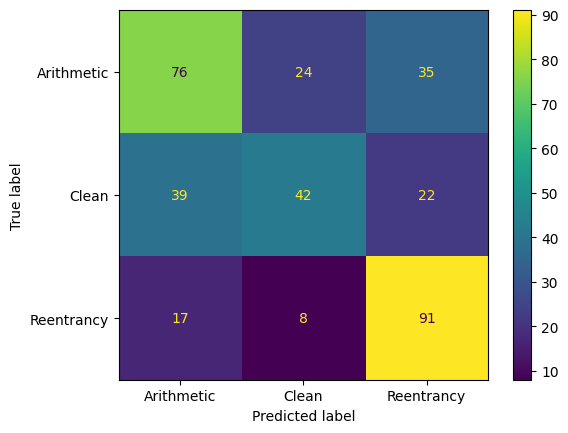

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_1, y_predicted_1)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Arithmetic", "Clean", "Reentrancy"])

cm_display.plot()
plt.show()

In [ ]:
model.save('saved_model/bert_mutil_data')

In [ ]:
model1 = tf.keras.models.load_model('saved_model/bert_mutil_data')

In [ ]:
model1.fit(df_train['source_code'], y_train, epochs=10, batch_size=32)

Epoch 1/10
45/45 [==============================] - 18s 162ms/step - loss: 0.5368 - accuracy: 0.7496 - precision: 0.6436 - recall: 0.5576
Epoch 2/10
45/45 [==============================] - 7s 160ms/step - loss: 0.5246 - accuracy: 0.7494 - precision: 0.6452 - recall: 0.5512
Epoch 3/10
45/45 [==============================] - 7s 160ms/step - loss: 0.5193 - accuracy: 0.7498 - precision: 0.6467 - recall: 0.5498
Epoch 4/10
45/45 [==============================] - 7s 159ms/step - loss: 0.5290 - accuracy: 0.7531 - precision: 0.6496 - recall: 0.5633
Epoch 5/10
45/45 [==============================] - 7s 160ms/step - loss: 0.5191 - accuracy: 0.7486 - precision: 0.6448 - recall: 0.5477
Epoch 6/10
45/45 [==============================] - 7s 160ms/step - loss: 0.5175 - accuracy: 0.7581 - precision: 0.6580 - recall: 0.5710
Epoch 7/10
45/45 [==============================] - 7s 161ms/step - loss: 0.5241 - accuracy: 0.7468 - precision: 0.6393 - recall: 0.5512
Epoch 8/10
45/45 [======================

In [ ]:
model1.evaluate(df_test['source_code'], y_test)

12/12 [==============================] - 3s 147ms/step - loss: 0.5210 - accuracy: 0.7702 - precision: 0.6884 - recall: 0.5678


[0.5210362076759338, 0.770244836807251, 0.6883561611175537, 0.5677965879440308]

In [ ]:
y_predicted1 = model1.predict(df_test['source_code'])
y_predicted1 = np.argmax(y_predicted1, axis=1)
y_test = np.argmax(y_test, axis=1)

12/12 [==============================] - 3s 146ms/step


In [ ]:
print(classification_report(y_test, y_predicted1))

              precision    recall  f1-score   support

           0       0.57      0.57      0.57       135
           1       0.60      0.47      0.52       103
           2       0.65      0.78      0.71       116

    accuracy                           0.61       354
   macro avg       0.61      0.61      0.60       354
weighted avg       0.61      0.61      0.60       354



In [ ]:
print(accuracy_score(y_test, y_predicted1))

0.6101694915254238


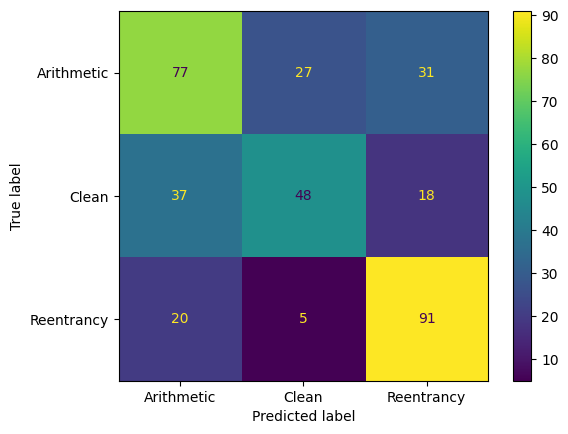

In [ ]:
cm = confusion_matrix(y_test, y_predicted1)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Arithmetic", "Clean", "Reentrancy"])

cm_display.plot()
plt.show()

In [ ]:
model1.save('saved_model/bert_mutil_data')

In [ ]:
model2 = tf.keras.models.load_model('saved_model/bert_mutil_data')

In [ ]:
model2.fit(df_train['source_code'], y_train, epochs=10, batch_size=32)

Epoch 1/10
45/45 [==============================] - 18s 162ms/step - loss: 0.5111 - accuracy: 0.7515 - precision: 0.6461 - recall: 0.5625
Epoch 2/10
45/45 [==============================] - 7s 161ms/step - loss: 0.5090 - accuracy: 0.7501 - precision: 0.6416 - recall: 0.5668
Epoch 3/10
45/45 [==============================] - 7s 161ms/step - loss: 0.5069 - accuracy: 0.7562 - precision: 0.6537 - recall: 0.5710
Epoch 4/10
45/45 [==============================] - 7s 162ms/step - loss: 0.5051 - accuracy: 0.7503 - precision: 0.6408 - recall: 0.5710
Epoch 5/10
45/45 [==============================] - 7s 160ms/step - loss: 0.5080 - accuracy: 0.7571 - precision: 0.6551 - recall: 0.5731
Epoch 6/10
45/45 [==============================] - 7s 161ms/step - loss: 0.5098 - accuracy: 0.7527 - precision: 0.6464 - recall: 0.5696
Epoch 7/10
45/45 [==============================] - 7s 159ms/step - loss: 0.5033 - accuracy: 0.7654 - precision: 0.6705 - recall: 0.5823
Epoch 8/10
45/45 [======================

In [ ]:
y_test2 = df_test['label'].values
y_test2 = to_categorical(y_test2)

In [ ]:
model2.evaluate(df_test['source_code'], y_test2)

12/12 [==============================] - 3s 149ms/step - loss: 0.5117 - accuracy: 0.7345 - precision: 0.6132 - recall: 0.5508


[0.5116562247276306,
 0.7344632744789124,
 0.6132075190544128,
 0.5508474707603455]

In [ ]:
import numpy as np
y_predicted2 = model2.predict(df_test['source_code'])
y_predicted2 = np.argmax(y_predicted2, axis=1)
y_test2 = np.argmax(y_test2, axis=1)

12/12 [==============================] - 3s 149ms/step


In [ ]:
print(classification_report(y_test2, y_predicted2))

              precision    recall  f1-score   support

           0       0.62      0.52      0.56       135
           1       0.55      0.52      0.54       103
           2       0.64      0.78      0.70       116

    accuracy                           0.61       354
   macro avg       0.60      0.61      0.60       354
weighted avg       0.61      0.61      0.60       354



In [ ]:
print(accuracy_score(y_test2, y_predicted2))

0.6073446327683616


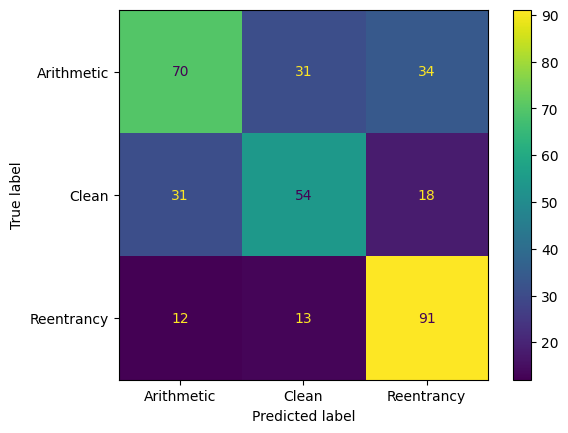

In [ ]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test2, y_predicted2)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["Arithmetic", "Clean", "Reentrancy"])

cm_display.plot()
plt.savefig("/content/drive/MyDrive/NCKH_Trinh_Kien_Hoang/Figure/KLTN/BERT_30.png", dpi=1200, transparent=True)
plt.show()